In [1]:
import os
import numpy as np
import pandas as pd
from random import sample
from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import warnings

# suppress warnings for matplotlib
warnings.filterwarnings('ignore')

# Generative AI EDA

This notebook will explore various aspects of the CelebA dataset, including attributes of the images in the dataset for each data split and visualiztions of the faces in the data.

In [2]:
# read in attribute and validation split data

attr = pd.read_csv(r"data/celeba/list_attr_celeba.csv", delimiter = ',', dtype = 'str')

eval = pd.read_csv(r"data/celeba/list_eval_partition.csv", delimiter = ',', dtype = 'str')

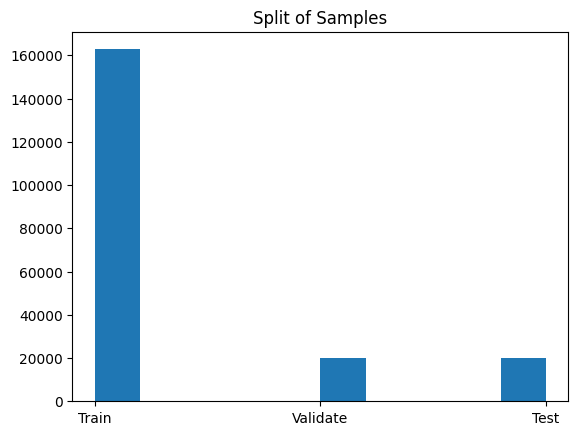

In [3]:
train_split = eval['partition'].hist()
train_split.set_title("Split of Samples")
train_split.set_xticklabels(['Train', 'Validate', 'Test'])
train_split.grid(False)

As you can see in the above plot, 10% of the data is in the validation set and 10% is in the testing set. Due to computational constraints, it is unlikely we will be able to train the model on all 160,000 training samples each epoch. Instead, we will need to randomly sample from the splits.

In [4]:
def show_sample_imgs(df1, attr, label_dict, base_dir, num_samples = 6):
    """
    Samples images for a given attribute and displays them.
    A matplotlib figure will be shown with a row for each class
    in the given attribute

    Args:
        df1 (pandas.DataFrame): The DataFrame.
        attr (str): The attribute to group by.
        label_dict (dict): Dictionary to map label values to strings
        base_dir (str): Directory for CelebA images
        num_samples (int): The number of samples for each class. Defaults to 6.

    Returns:
        None
    """

    # randomly sample rows from dataset with a given attribute
    samps_by_group = []
    factors = []
    for factor_value, group in df1.groupby(attr):
        samps_by_group.append(group['image_id'].sample(n=num_samples))
        factors.append(factor_value)

    # Create the figure and add each subplot to it
    fig, axs = plt.subplots(len(samps_by_group), num_samples, figsize=(10, 3))

    for i in range(len(samps_by_group)):
        for j, pth in enumerate(samps_by_group[i]):
            img = Image.open(os.path.join(base_dir, pth))
            axs[i][j].imshow(np.array(img))
            axs[i][j].set_title(label_dict[factors[i]])
            axs[i][j].axis(False)

    # Adjust spacing and show the plot
    fig.suptitle(f'Sample Images for {attr} Attribute')
    fig.tight_layout()
    plt.show()


def join_and_plot(df1, df2, join_key, factor_column, to_plot, title_dict, x_lab_dict, ylim, bins=10):
    """
    Joins two Pandas DataFrames on a given key and plots histograms for a specific column for a given factor.
    Edited from function generated by ChatGPT

    Args:
        df1 (pandas.DataFrame): The first DataFrame to join.
        df2 (pandas.DataFrame): The second DataFrame to join.
        join_key (str): The name of the column to join on.
        factor_column (str): The name of the column to group by and plot histograms for.
        to_plot (str): The name of the column to plot
        title_dict (dict): Dictionary to map title variables to strings
        x_lab_dict (dict): Dictionary to map factor variables to strings
        ylim (int): limit for each y axis
        bins (int): The number of bins to use in the histogram. Defaults to 10.

    Returns:
        None
    """
    # Join the two DataFrames on the given key
    merged_df = pd.merge(df1, df2, on=join_key)

    # Group the DataFrame by the given factor column and plot histograms
        # Get the number of subplots and calculate the number of rows and columns
    num_subplots = len(merged_df.groupby(factor_column))
    num_rows = int(num_subplots ** 0.5)
    num_cols = int(num_subplots / num_rows) + int(num_subplots % num_rows > 0)

    # Create the figure and add each subplot to it
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 3))

    # Flatten axs if needed
    if num_subplots == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    i = 0
    for factor_value, group in merged_df.groupby(factor_column):
        axs[i].hist(group[to_plot], bins=bins, alpha=0.5, label=str(factor_value))
        axs[i].set_xticklabels([x_lab_dict[i] for i in group[to_plot].unique()])
        axs[i].set_title(f'Count of {to_plot} in {title_dict[factor_value]} Set')
        i += 1

    # Adjust spacing and show the plot
    fig.tight_layout()
    plt.show()


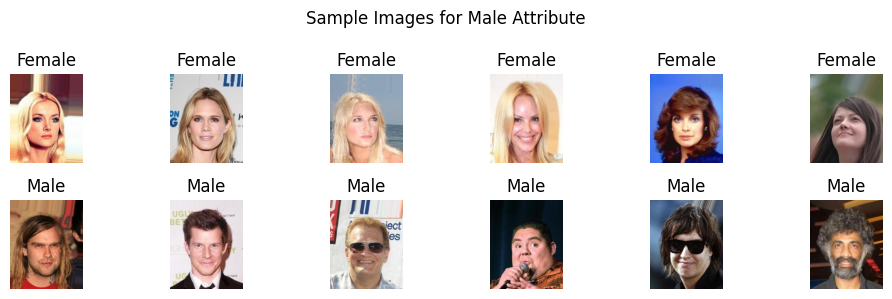

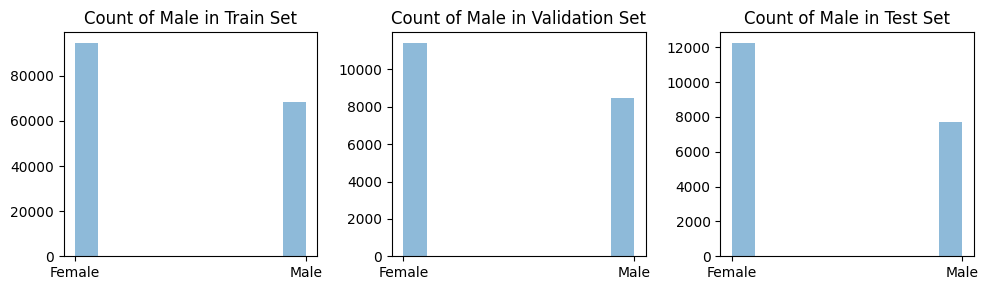

In [5]:
title_dict = {
    '0': 'Train',
    '1': 'Validation',
    '2': 'Test'
}

x_lab_dict = {
    '-1' : 'Female',
    '1' : 'Male'
}

max_y = 100000

show_sample_imgs(attr, 'Male', x_lab_dict, r'data/celeba/img_align_celeba')

join_and_plot(attr, eval, 'image_id', 'partition', 'Male', title_dict, x_lab_dict, max_y)

As you can see, the classes for gender are unbalanced for each split. This could potentially lead our model to performing better on female faces over male ones. In order to combat this, we can experiment with weighted random sampling to ensure the model is trained on equal splits for each gender.

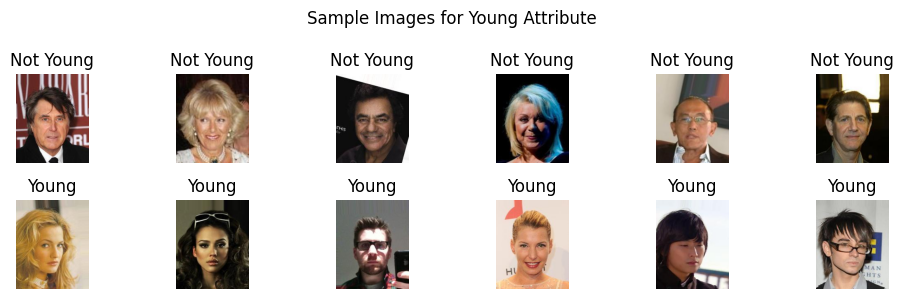

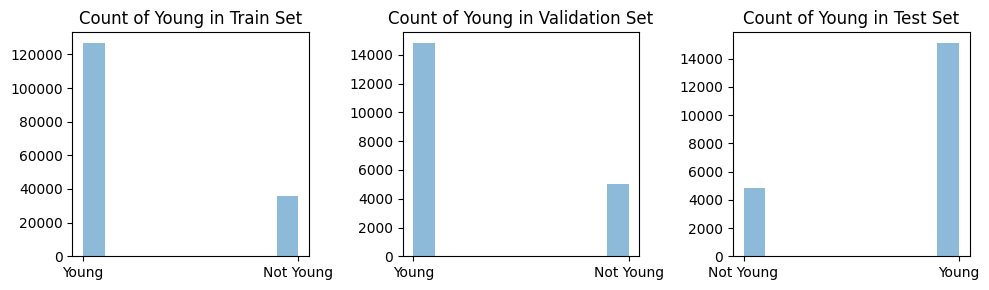

In [6]:
x_lab_dict = {
    '-1' : 'Not Young',
    '1' : 'Young'
}

max_y = 150000

show_sample_imgs(attr, 'Young', x_lab_dict, r'data/celeba/img_align_celeba')

join_and_plot(attr, eval, 'image_id', 'partition', 'Young', title_dict, x_lab_dict, max_y)

The splits for young versus not young are even more imbalanced than the counts of gender for the training, validation, and test sets. Again, we could experiement with weighted random sampling to try to counteract the class imbalance in this dataset.

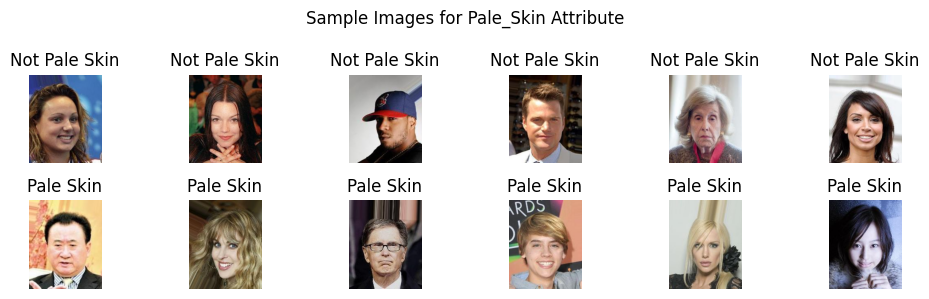

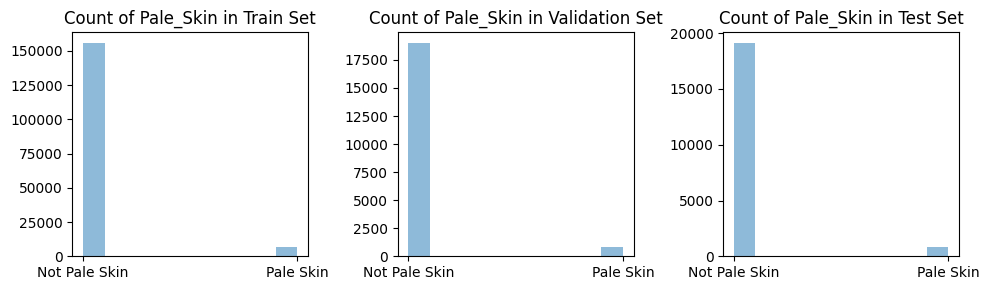

In [7]:
x_lab_dict = {
    '-1' : 'Not Pale Skin',
    '1' : 'Pale Skin'
}

max_y = 200000

show_sample_imgs(attr, 'Pale_Skin', x_lab_dict, r'data/celeba/img_align_celeba')

join_and_plot(attr, eval, 'image_id', 'partition', 'Pale_Skin', title_dict, x_lab_dict, max_y)

It is a well known problem that generative AI models reflect the biases in the data they are trained on. However, as you can see in the sample images, the 'Pake Skin' attribute does not separate the dataset by race or ethnicity, so it cannot be used to assess the degree of bias in our models. It is important that we recognize the racial or ethnic biases that can arise from the models we train, since the CelebA dataset is inherently biased.

## Bivariate Analysis

Next, we'll look for any correlation between the various attributes we are interested in: 'Pale Skin', 'Male', and 'Young'. Since we will be working with each split of the dataset separately, we have chosen to create a heatmap of the cross-correlation for each split in the dataset.

In [8]:
def join_and_corr(df1, df2, join_key, factor_column, to_plot, title_dict, x_lab_dict, ylim, bins=10):
    """
    Joins two Pandas DataFrames on a given key and plots histograms for a specific column for a given factor.
    Edited from function generated by ChatGPT

    Args:
        df1 (pandas.DataFrame): The first DataFrame to join.
        df2 (pandas.DataFrame): The second DataFrame to join.
        join_key (str): The name of the column to join on.
        factor_column (str): The name of the column to group by and plot histograms for.
        to_plot (str): The name of the column to plot
        title_dict (dict): Dictionary to map title variables to strings
        x_lab_dict (dict): Dictionary to map factor variables to strings
        ylim (int): limit for each y axis
        bins (int): The number of bins to use in the histogram. Defaults to 10.

    Returns:
        None
    """
    # Join the two DataFrames on the given key
    merged_df = pd.merge(df1, df2, on=join_key)

    for factor_value, group in merged_df.groupby(factor_column):
        temp_df = group.filter(['Male','Pale_Skin', 'Young'], axis=1)
        cor_matrix = temp_df.astype('float64').corr()
        cor_matrix = cor_matrix.style.set_caption(f'Cross-Correlation in {title_dict[factor_value]} Set')
        display(cor_matrix) # convert from string to float


In [9]:
join_and_corr(attr, eval, 'image_id', 'partition', 'Pale_Skin', title_dict, x_lab_dict, max_y)

,Male,Pale_Skin,Young
Male,1.000000,-0.076239,-0.291788
Pale_Skin,-0.076239,1.000000,0.044395
Young,-0.291788,0.044395,1.000000


,Male,Pale_Skin,Young
Male,1.000000,-0.084941,-0.256603
Pale_Skin,-0.084941,1.000000,0.035300
Young,-0.256603,0.035300,1.000000


,Male,Pale_Skin,Young
Male,1.000000,-0.081292,-0.253904
Pale_Skin,-0.081292,1.000000,0.044806
Young,-0.253904,0.044806,1.000000


Here we see that the correlation values are very similar among each split in the dataset. In addition, none of these variables are strongly correlated.

## Pixel Value Distributions

Finally, we'll examine the color distributions for the images in the dataset. This is particularly helpful if we choose to use RGB images, since proper normalization is a common pre-processing technique in generative models, as we want to ensure that each image reflects the same color distribution.

In [12]:
def get_dist(dir, num_samples):
    """
    Return distributions of pixels in a directory of images

    :param dir : Directory with images
    :type dir: str
    :param num_samples: Number of images you want to sample
    :type num_samples: int
    :return: 4 arrays for black and white distribution, red channel, green channel, blue channel
    :rtype: ndarray, ndarray, ndarray, ndarray
    """
    all_files = os.listdir(dir)

    # since there are 200,000 images, randomly sample a subset
    files = sample(all_files, num_samples)

    total_dist = np.zeros((len(files), 38804))
    red_dist = np.zeros((len(files), 38804))
    green_dist = np.zeros((len(files), 38804))
    blue_dist = np.zeros((len(files), 38804))

    # use tqdm to show a progress bar
    for i in tqdm(range(len(files))):
        # get image
        with Image.open(os.path.join(dir, files[i])) as im:
            red_dist[i, :] = np.array(im)[:, :, 0].ravel()
            green_dist[i, :] = np.array(im)[:, :, 1].ravel()
            blue_dist[i, :] = np.array(im)[:, :, 2].ravel()

            # convert to grayscale
            im = ImageOps.grayscale(im)
            # convert to numpy array
            total_dist[i, :] = np.array(im).ravel()

    return total_dist, red_dist, green_dist, blue_dist

def plot_dists(bw, color_channels, title):
    """
    Plot color distributions

    :param bw: Array of values for black and white channel
    :type bw: ndarray
    :param color_channels: List of arrays corresponding to red, blue, and green channels
    :type color_channels: list
    :param title: Title for plot
    :type title: str
    """
    # Create the figure and add each subplot to it
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Color channels
    colors = ("red", "green", "blue")

    # Create histogram with a line for each color
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            color_channels[channel_id], bins=256, range=(0, 256) # maximum value is 255
        )
        axs[0].plot(bin_edges[0:-1], histogram, color=color)

    axs[0].set_title('Color Histogram')

    histogram, bin_edges = np.histogram(
            bw, bins=256, range=(0, 256)
        )

    axs[1].plot(bin_edges[0:-1], histogram)
    axs[1].set_title('B&W Histogram')

    # Adjust spacing and show the plot
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


In [13]:
dist, r, g, b = get_dist(r'data/celeba/img_align_celeba', 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

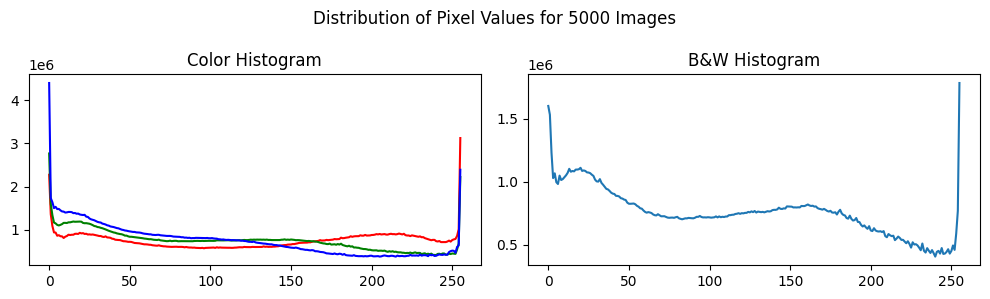

In [15]:
plot_dists(dist, [r, g, b], "Distribution of Pixel Values for 5000 Images")

First, let's talk about the color distributions across 5000 samples from the dataset. As we would expect, there are many more extreme value, 0 and 255, than other values in the dataset. In addition, red is the dominant color channel, since skin tones are naturally warmer.

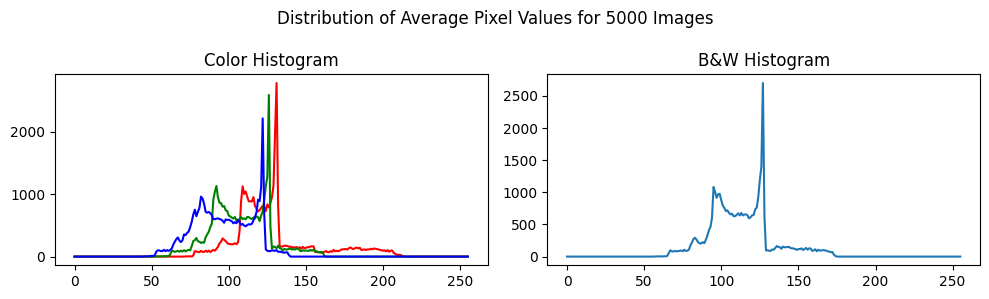

In [16]:
# get average value of each pixel
plot_dists(np.mean(dist, axis = 0), [np.mean(r, axis = 0), np.mean(g, axis = 0), np.mean(b, axis = 0)],
           "Distribution of Average Pixel Values for 5000 Images")

Next, we'll look at the histograms for the average pixel values for 5000 images. These values were calculated by finding the average value for each pixel, and then plotting the resulting distribution. Interestingly, these histograms show a bimodal distribution. Again, red is the predominant color channel, as we would expect. As we move on with our project, we can use these histograms to generate values to standardize the images, by finding the mean and variance of these distributions.